# Entity Resolution- Dedupe Model

In [1]:
# Import Statements
from __future__ import print_function
from future.builtins import next

import os
import csv
import re
import collections
import numpy

import dedupe
from unidecode import unidecode

Setup

In [2]:
# the output_file will store the results of the record linkage deduplication
output_file = 'data_matching_output.csv'

# the settings file will contain the data model and predicates
settings_file = 'data_matching_learned_settings'

# the training_file will contain the pairs of labeled examples that the model was trained on
training_file = 'data_matching_training.json'


In [3]:
# method to clean the data using Unidecode and Regex

def preProcess(column):
    # convert any unicode data into ASCII characters
    column = unidecode(column)
    # ignore new lines
    column = re.sub('\n', ' ', column)
    # ignore special characters
    column = re.sub('-', '', column)
    column = re.sub('/', ' ', column)
    column = re.sub("'", '', column)
    column = re.sub(",", '', column)
    column = re.sub(":", ' ', column)
    # ignore extra white space
    column = re.sub('  +', ' ', column)
    # ignore casing
    column = column.strip().strip('"').strip("'").lower().strip()
    if not column :
        column = None
    return column


In [4]:
# Read the data from the CSV and create a dictionary of addresses

def readData(filename):
    
    # initialize the dictionary
    data_d = {}

    # read each row in the CSV, clean the data, and it to a dictionary
    with open(filename) as f:
        reader = csv.DictReader(f)
        for i, row in enumerate(reader):
            clean_row = dict([(k, preProcess(v)) for (k, v) in row.items()])
            # each address will have a unique ID consisting of the file name and a unique number
            data_d[filename + str(i)] = dict(clean_row)

    return data_d

In [5]:
# Import the data
data_1 = readData('addresses.csv')
data_2 = readData('user_entries.csv')

Train the model

In [6]:
# if there already exists a settings_file (with the data model),
# create a Dedupe object (linker) that will load the saved settings
if os.path.exists(settings_file):
    print('reading from', settings_file)
    with open(settings_file, 'rb') as sf :
        linker = dedupe.StaticRecordLink(sf)

# if there is no previously saved settings data, create it
else:
    # Define the fields the linker will pay attention to
    # Specifying fields refines the comparison methods so not each part of the record are compared equally
    # for example, dedupe will learn which of these fields have higher weights (more important in determining matches) by using regularized logistic regression
    # String types compared using affine gap string distance
    # Note- the address field is only for US addresses (uses usaddress package to split into components)
        # must have dedupe-variable-address installed to use this
    fields = [
        {'field' : 'title', 'type': 'String'},
        {'field' : 'title', 'type': 'Address'},
        {'field' : 'description', 'type': 'String'},
        {'field' : 'description', 'type': 'Address'}]
    
    # Create a new linker object and pass the data model to it.
    linker = dedupe.RecordLink(fields)
    # To train the linker, feed it a sample of records.
    linker.sample(data_1, data_2, 70)

    
    # If we have training data saved from a previous run of linker,
    # look for it and load it in.
    if os.path.exists(training_file):
        print('reading labeled examples from ', training_file)
        with open(training_file) as tf :
            linker.readTraining(tf)

    # ## Active learning
    # Dedupe will find the next pair of records
    # it is least certain about and ask for them to be labelled as matches
    # or not.
    print('starting active labeling...')

    # Label examples, add them to the training data, and update the mathcing model
    dedupe.consoleLabel(linker)

    linker.train()

    # When finished, save training data as labeled examples in the training_file
    with open(training_file, 'w') as tf :
        linker.writeTraining(tf)

    # Save weights and predicates.  If the settings file
    # exists, skip all the training and learning next time we run
    # this file.
    with open(settings_file, 'wb') as sf :
        linker.writeSettings(sf)

INFO:dedupe.api:((LevenshteinSearchPredicate: (3, title), SimplePredicate: (hundredIntegerPredicate, description)), (PartialPredicate: (metaphoneToken, title, StreetName), SimplePredicate: (fingerprint, description)), (PartialPredicate: (alphaNumericPredicate, title, StreetName), TfidfNGramSearchPredicate: (0.6, description)))


reading from data_matching_learned_settings


Blocking

In [7]:
import itertools

# Split the data up into groups of records with some feature in common
# Only comparing the entries in these blocks reduces number of comparisons
# This is more useful with larger datasets- where we would use a representative sample rather than all the data
# 2 blocking methods- predicate blocks and index
blocks = linker._blockData(data_1,data_2)

Calculate precision, recall, threshold

In [8]:
# that the records will be duplicates
candidate_records = itertools.chain.from_iterable(linker._blockedPairs(blocks))

# Calculate the probability that pair of records are duplicates
probability = dedupe.core.scoreDuplicates(candidate_records,
                                           linker.data_model,
                                           linker.classifier,
                                           linker.num_cores)['score']

probability = probability.copy()
probability.sort()
probability = probability[::-1]

expected_dupes = numpy.cumsum(probability)

# Recall- TP/(TP + FN) - ability to find all interesting data points
recall = expected_dupes / expected_dupes[-1]
# Precision- TP/(TP + FP) - take the probability that the pairs are duplicates divided by the total number of duplicates
precision = expected_dupes / numpy.arange(1, len(expected_dupes) + 1)

INFO:dedupe.api:0 records
/anaconda/lib/python3.6/site-packages/dedupe/backport.py:20: UserWarning: NumPy linked against 'Accelerate.framework'. Multiprocessing will be disabled. http://mail.scipy.org/pipermail/numpy-discussion/2012-August/063589.html
  warnings.warn("NumPy linked against 'Accelerate.framework'. "
INFO:dedupe.api:100 records


In [9]:
print("probability:", probability)
print("expected duplicates:", expected_dupes)
print("recall:",recall)
print("precision:",precision)

probability: [0.9999942  0.9999916  0.9999916  0.9999916  0.9999916  0.9999916
 0.9999916  0.9999916  0.99998796 0.99996525 0.99995244 0.99995106
 0.99995095 0.9999365  0.99993217 0.9998862  0.99986833 0.9997867
 0.99978435 0.9997037  0.99966604 0.99958724 0.99951833 0.9994794
 0.9990729  0.99901253 0.9987339  0.9981731  0.9976735  0.9952801
 0.9929538  0.99244595 0.98742485 0.98170614 0.9698193  0.95437074
 0.942206   0.9311108 ]
expected duplicates: [ 0.9999942  1.9999858  2.9999774  3.999969   4.9999604  5.999952
  6.9999433  7.9999347  8.999923   9.999888  10.999841  11.999792
 12.999743  13.99968   14.999612  15.999498  16.999367  17.999153
 18.998938  19.998642  20.998308  21.997896  22.997414  23.996893
 24.995966  25.994978  26.993711  27.991884  28.989557  29.984837
 30.97779   31.970238  32.957664  33.93937   34.909187  35.86356
 36.805767  37.736877 ]
recall: [0.02649912 0.05299818 0.07949723 0.10599629 0.13249534 0.15899439
 0.18549344 0.21199249 0.23849146 0.26498982 0.291

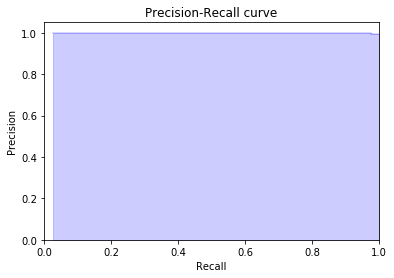

In [10]:
# Display the predicted precision-recall plot

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt


plt.step(recall, precision, color='b', alpha=.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')
plt.show()

Clustering

In [11]:
# Find the threshold that will maximize a weighted average of our
# precision and recall (F Score) for a sample of data.  When we set the recall weight to 2, we are
# saying we care twice as much about recall as we do precision.
#
# The weighted avg, or F-score = 2tp/(2tp + fp + fn)
# 
# In this case, set the recall_weight to .5- saying we care twice as much about precision
# as we do recall. When matching the data, set the threshold closer to 1 to raise precision
# 
# This is called hierarchical clustering with centroid linkage
# Example- A is related to B, C is related to B, so those would all be clustered with B as centroid
# The threshold determine the minimum probability for a record to be related to the centroid

recall_weight = .5

score = recall * precision / (recall + recall_weight ** 2 * precision)

i = numpy.argmax(score)

print('Maximum expected recall and precision')
print('recall: %2.3f', recall[i])
print('precision: %2.3f', precision[i])
print('With threshold: %2.3f', probability[i])

calcThreshold= probability[i]

print("Threshold to maximize expected F score =", calcThreshold )


print('clustering...')
linked_records = linker.match(data_1, data_2, threshold=calcThreshold)

INFO:dedupe.api:0 records
INFO:dedupe.api:100 records


Maximum expected recall and precision
recall: %2.3f 1.0
precision: %2.3f 0.9930757221422697
With threshold: %2.3f 0.9311108
Threshold to maximize expected F score = 0.9311108
clustering...


In [12]:
print('# duplicate sets', len(linked_records))

# duplicate sets 21


Write results

In [13]:
# Write our original data back out to a CSV with a new column called 
# 'Cluster ID' which indicates which records refer to each other.

cluster_membership = {}
cluster_id = None
for cluster_id, (cluster, score) in enumerate(linked_records):
    for record_id in cluster:
        cluster_membership[record_id] = (cluster_id, score)

if cluster_id :
    unique_id = cluster_id + 1
else :
    unique_id =0

In [14]:
with open(output_file, 'w') as f:
    writer = csv.writer(f)
    
    header_unwritten = True

    for fileno, filename in enumerate(('addresses.csv', 'user_entries.csv')) :
        with open(filename) as f_input :
            reader = csv.reader(f_input)

            if header_unwritten :
                heading_row = next(reader)
                heading_row.insert(0, 'source file')
                heading_row.insert(0, 'Link Score')
                heading_row.insert(0, 'Cluster ID')
                writer.writerow(heading_row)
                header_unwritten = False
            else :
                next(reader)

            for row_id, row in enumerate(reader):
                cluster_details = cluster_membership.get(filename + str(row_id))
                if cluster_details is None :
                    cluster_id = unique_id
                    unique_id += 1
                    score = None
                else :
                    cluster_id, score = cluster_details
                row.insert(0, fileno)
                row.insert(0, score)
                row.insert(0, cluster_id)
                writer.writerow(row)

In [181]:
addr = input('Enter the street address: ')
city = input('Enter the city: ')
state = input('Enter the state: ')
zip_code = input('Enter the zip code: ')

# create a new file that will contain the user's entry
user_input_file = 'user_input_file.csv'
with open (user_input_file, 'w', newline='') as csvfile:
    fieldnames = ['unique_id','title', 'description']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerow({'unique_id' : "1", 'title': addr, 'description': city +" " + state + " " + " " + (zip_code)})

Enter the street address: 7 Brock Ave
Enter the city: Abing
Enter the state: MA
Enter the zip code: 231


In [98]:
fields = [{'field' : 'title', 'type': 'String'},
        {'field' : 'title', 'type': 'Address'},{'field':'description', 'type':'String'},{'field':'description', 'type':'Address'}]
    
duper = dedupe.RecordLink(fields)

In [182]:
data_entry = readData('user_input_file.csv')

In [177]:
data_1

{'addresses.csv0': {'description': 'abington ma 2351',
  'title': '777 brockton avenue',
  'unique_id': '1'},
 'addresses.csv1': {'description': 'avon ma 2322',
  'title': '30 memorial drive',
  'unique_id': '2'},
 'addresses.csv10': {'description': 'framingham ma 1701',
  'title': '121 worcester rd',
  'unique_id': '11'},
 'addresses.csv100': {'description': 'avon ct 6001',
  'title': '255 w main st',
  'unique_id': '100'},
 'addresses.csv101': {'description': 'branford ct 6405',
  'title': '120 commercial parkway',
  'unique_id': '101'},
 'addresses.csv102': {'description': 'bristol ct 6010',
  'title': '1400 farmington ave',
  'unique_id': '102'},
 'addresses.csv103': {'description': 'cromwell ct 6416',
  'title': '161 berlin road',
  'unique_id': '103'},
 'addresses.csv104': {'description': 'danbury ct 6810',
  'title': '67 newton rd',
  'unique_id': '104'},
 'addresses.csv105': {'description': 'derby ct 6418',
  'title': '656 new haven ave',
  'unique_id': '105'},
 'addresses.csv1

In [179]:
data_entry

{'user_input_file.csv0': {'description': 'abington ma 2351',
  'title': '777 brockton avenue',
  'unique_id': '1'}}

In [47]:
# now, need to update the settings file and training file
# stop the previous section when user enters y
# train data for when user enters entire address in 1 line

In [78]:
user_blocks = linker._blockData(data_1,data_entry)

In [79]:
duplicates = linker.matchBlocks(user_blocks)

In [161]:
dict_list = []
fields= ['unique_id', 'title', 'description']
with open('addresses.csv', mode='r') as infile:
    reader = csv.reader(infile)
    next(reader)
    for rows in reader:
        dictionary = {}
        for i in range(3):
            dictionary[fields[i]] = rows[i]
        dict_list.append(dictionary)
dict_list2 = []
fields= ['unique_id', 'title', 'description']
with open('user_input_file.csv', mode='r') as infile:
    reader = csv.reader(infile)
    next(reader)
    for rows in reader:
        dictionary = {}
        for i in range(3):
            dictionary[fields[i]] = rows[i]
        dict_list2.append(dictionary)

In [162]:
type(dict_list[0]['title'])

str

In [164]:
type(dict_list2[0]['title'])

str

In [121]:
data_1

{'addresses.csv0': {'description': 'abington ma 2351',
  'title': '777 brockton avenue',
  'unique_id': '1'},
 'addresses.csv1': {'description': 'avon ma 2322',
  'title': '30 memorial drive',
  'unique_id': '2'},
 'addresses.csv10': {'description': 'framingham ma 1701',
  'title': '121 worcester rd',
  'unique_id': '11'},
 'addresses.csv100': {'description': 'avon ct 6001',
  'title': '255 w main st',
  'unique_id': '100'},
 'addresses.csv101': {'description': 'branford ct 6405',
  'title': '120 commercial parkway',
  'unique_id': '101'},
 'addresses.csv102': {'description': 'bristol ct 6010',
  'title': '1400 farmington ave',
  'unique_id': '102'},
 'addresses.csv103': {'description': 'cromwell ct 6416',
  'title': '161 berlin road',
  'unique_id': '103'},
 'addresses.csv104': {'description': 'danbury ct 6810',
  'title': '67 newton rd',
  'unique_id': '104'},
 'addresses.csv105': {'description': 'derby ct 6418',
  'title': '656 new haven ave',
  'unique_id': '105'},
 'addresses.csv1

In [183]:
linker.match(data_1,data_entry)

INFO:dedupe.api:0 records
INFO:dedupe.api:100 records


BlockingError: No records have been blocked together. Is the data you are trying to match like the data you trained on?

{'user_input_file.csv0': {'description': 'abigton ma 2351',
  'title': '777 brockton avenue',
  'unique_id': '4'}}